<a href="https://colab.research.google.com/github/keilabcs/IN1024-UFPE/blob/main/Classifica%C3%A7%C3%A3o_de_Coronav%C3%ADrus_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Universidade Federal de Pernambuco - UFPE

Pós-Graduaçao em Ciências da Computação - Cin

Keila Barbosa Costa dos Santos

Disciplina IN1024 - Processamento de Imagens - Cin/UFPE - 2020.1 por Tsang Ing Ren.

---

**Projeto Final - 2** 

### Detecção de Pneumonia - Multiclass 

Detectar várias causas de pneumonia em radiografias de tórax.

Não apenas separar os pulmões saudáveis ​​dos infectados com pneumonia, mas também tentar discriminar entre as diferentes causas da pneumonia, sejam elas causadas por bactérias, SARS-CoV-2 ou algum outro vírus.

Os exames de raio-X do pulmão são uma forma comum de diagnosticar doenças respiratórias graves. Com os hospitais com capacidade máxima ou quase total, é importante que os médicos sejam capazes de determinar com precisão se um paciente está doente.

As soluções baseadas em IA foram recentemente exploradas extensivamente para o uso da detecção
de pneumonia em estudos, e essas abordagens também foram propostas durante esta pandemia.
Modelos personalizados foram relatados para atingir taxas de sensibilidade e especificidade de
aproximadamente 90%.

No entanto, sua especificidade na identificação da causa da pneumonia, particularmente contra
outras doenças virais (como a gripe), ainda está sendo debatida calorosamente. 


In [ ]:
from numpy.random import seed
seed(8) 
import tensorflow as tf
tf.random.set_seed(7) 
import os
import numpy as np # linear algebra
import pandas as pd # processamento de dados, E/S de arquivo CSV (por exemplo, pd.read_csv)

# Ambiente GPU
# Arquivos de dados de entrada estão disponíveis no diretório "../input/".
# Por exemplo, executando isto (clicando em executar ou pressionando Shift + Enter) irá listar os arquivos no diretório de entrada

In [ ]:
# Upgrade and install essential libraries
!pip install keras --upgrade
!pip install zipfile36
!pip install pydicom

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


### Metodologia

O conjunto de dados foi dividido em:

*   80% dos dados para treinamento 
*   20% dos dados para testes

Criado a partir da junção dos conjuntos:

https://www.kaggle.com/tawsifurrahman/covid19-radiography-database?

https://github.com/ieee8023/covid-chestxray-dataset

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

https://data.mendeley.com/datasets/rscbjbr9sj/2

* Saudável: 1341 Imagens
* Pneumonia (viral): 1368 Imagens
* Pneumonia (Bacteriana): 2404 Imagens
* Pneumonia (COVID-19): 254 Imagens

In [ ]:
# Importar conjunto de dados
!gdown https://drive.google.com/a/cin.ufpe.br/uc?id=1WgdiuSnUwuDGNZQbkeszvYVVGl4bgT6L&export=download

Downloading...
From: https://drive.google.com/a/cin.ufpe.br/uc?id=1WgdiuSnUwuDGNZQbkeszvYVVGl4bgT6L
To: /content/Covid_Data_GradientCrescent.zip
2.18GB [00:27, 80.7MB/s]


In [ ]:
# Descompacte o conjunto de dados
#!unzip -o /content/Covid_Data_GradientCrescent.zip
!unzip Covid_Data_GradientCrescent.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: __MACOSX/Covid_Data_GradientCrescent/all/train/pneumonia_vir/._person1227_virus_2078.jpeg  
  inflating: Covid_Data_GradientCrescent/all/train/pneumonia_vir/person1228_virus_2079.jpeg  
  inflating: __MACOSX/Covid_Data_GradientCrescent/all/train/pneumonia_vir/._person1228_virus_2079.jpeg  
  inflating: Covid_Data_GradientCrescent/all/train/pneumonia_vir/person1229_virus_2080.jpeg  
  inflating: __MACOSX/Covid_Data_GradientCrescent/all/train/pneumonia_vir/._person1229_virus_2080.jpeg  
  inflating: Covid_Data_GradientCrescent/all/train/pneumonia_vir/person1230_virus_2081.jpeg  
  inflating: __MACOSX/Covid_Data_GradientCrescent/all/train/pneumonia_vir/._person1230_virus_2081.jpeg  
  inflating: Covid_Data_GradientCrescent/all/train/pneumonia_vir/person1231_virus_2088.jpeg  
  inflating: __MACOSX/Covid_Data_GradientCrescent/all/train/pneumonia_vir/._person1231_virus_2088.jpeg  
  inflating: Covid_Data_GradientCrescent

In [ ]:
print(os.listdir("/content/"))

# Remover zips quando terminar
!rm Covid_Data_GradientCrescent.zip

['.config', '.ipynb_checkpoints', '__MACOSX', 'Covid_Data_GradientCrescent.zip', 'Covid_Data_GradientCrescent', '1', 'sample_data']


In [ ]:
# Habilite esta célula para remover a classe de pneumonia viral or all. 
# Lembre-se de alterar a camada final do modelo para 3 ou 4 neurônios.

# Exclua algumas classes que podem interferir
!rm -rf /content/Covid_Data_GradientCrescent/all/train/.DS_Store

Vamos dar uma olhada no caso de quatro classes que incorpora outras causas virais de pneumonia.

In [ ]:
from os import listdir
data_list = listdir('/content/Covid_Data_GradientCrescent/all/train')

data_list

['pneumonia_bac', 'covid', 'normal', 'pneumonia_vir']

### Inicialização de VGG COVID19 vs Normal vs Pneumonia Terciária (Bacteriana e Viral) 

*   4 Classes




In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

In [ ]:
DATASET_PATH  = '/content/Covid_Data_GradientCrescent/all/train'
test_dir =  '/content/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # Tente reduzir o tamanho do lote ou congelar mais camadas se sua GPU ficar sem memória
NUM_EPOCHS    = 10 # O número de épocas de treinamento é aumentado, para acomodar o aumento da complexidade situacional. Da mesma forma, a taxa de aprendizagem foi reduzida para 1E-4.
LEARNING_RATE = 0.0001

In [ ]:
# Treinar dados pré-processador
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.25,
                                   zoom_range = 0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode = 'constant')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


O parâmetro class_mode em nossa classe ImageDataGenerator é definido como “categórico”.

In [ ]:
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  subset = "training",
                                                  seed = 42,
                                                  class_mode = "categorical")

Found 3332 images belonging to 4 classes.


In [ ]:
valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  subset = "validation",
                                                  seed = 42,
                                                  class_mode = "categorical")

Found 829 images belonging to 4 classes.



*   Modificação de camada na camada superior de VGG16.
*   **Modelo CNN** simples baseado em VGG16. 
*  Defina a contagem de neurônios de camada densa para 3 se a classe de pneumonia viral for removida.


In [ ]:
from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

conv_base.trainable = False

# O número de neurônios na camada final densamente conectada agora corresponde ao número de classes 3 ou 4 consideradas, 
#com uma função de ativação softmax anexada. 
# Isso permitirá fornecer uma saída de probabilidade para cada uma das classes e tomar o máximo como nossa saída final prevista.

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(4, activation = 'softmax'))

# O modelo agora está compilado com uma função de perda categorical_crossentropy .
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(lr = LEARNING_RATE),
              metrics=['acc', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")])


In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 16,813,124
Trainable params: 2,098,436
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
#Definindo callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Covid_Multi.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

### Training

In [ ]:
# Treinamento
# MODELO FIT
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN = train_batches.n//train_batches.batch_size
STEP_SIZE_VALID = valid_batches.n//valid_batches.batch_size

result = model.fit_generator(train_batches,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        callbacks = [checkpoint_cb, early_stopping_cb],
                        epochs= NUM_EPOCHS)

334
83
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


333/333 [==============================] - 68s 203ms/step - loss: 0.9652 - acc: 0.5789 - precision: 0.6652 - recall: 0.4413 - val_loss: 0.8568 - val_acc: 0.6354 - val_precision: 0.7216 - val_recall: 0.4805
Epoch 2/10
333/333 [==============================] - 65s 196ms/step - loss: 0.7947 - acc: 0.6595 - precision: 0.7135 - recall: 0.5554 - val_loss: 0.7328 - val_acc: 0.6793 - val_precision: 0.7225 - val_recall: 0.6098
Epoch 3/10
333/333 [==============================] - 65s 195ms/step - loss: 0.7529 - acc: 0.6806 - precision: 0.7218 - recall: 0.5966 - val_loss: 0.7283 - val_acc: 0.6890 - val_precision: 0.7260 - val_recall: 0.6268
Epoch 4/10
333/333 [==============================] - 65s 194ms/step - loss: 0.7419 - acc: 0.6803 - precision: 0.7214 - recall: 0.6198 - val_loss: 0.6785 - val_acc: 0.7037 - val_precision: 0.7585 - val_recall: 0.6549
Epoch 5/10
333/333 [==============================] - 64s 194ms/step - loss: 0.6922 - acc: 0.6972 - precision: 0.7335 - recall: 0.6388 - val_lo

### Avaliação

### Results (4 classes: Normal, Bacteriana, Viral, COVID19)

Vamos ver os resultados do treinamento ao considerar 4 classes (Saudável, COVID-19, Bacteriana, Viral), após o treinamento por 10 épocas a uma taxa de aprendizagem de 5E-4.

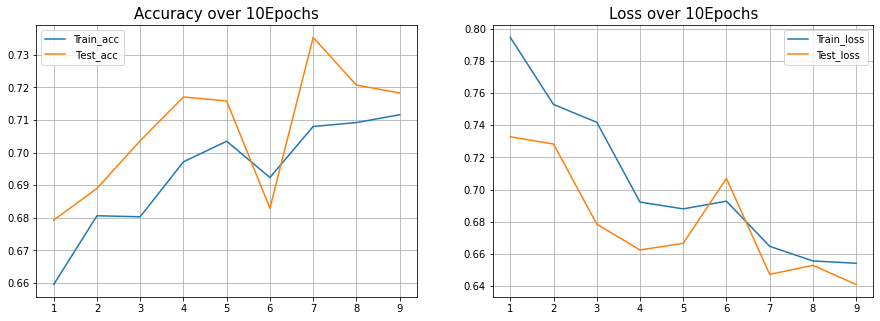

In [ ]:
# Avaliação
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize = (15, 5))
    plt.subplot(121)
    plt.plot(range(1, epochs), acc[1:], label = 'Train_acc')
    plt.plot(range(1, epochs), val_acc[1:], label =' Test_acc')
    plt.title('Accuracy over ' + str(epochs) + 'Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1, epochs), loss[1:], label = 'Train_loss')
    plt.plot(range(1, epochs), val_loss[1:], label = 'Test_loss')
    plt.title('Loss over ' + str(epochs) + 'Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 10)

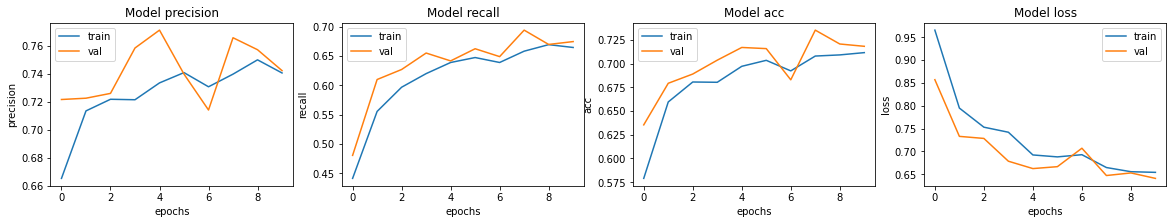

In [ ]:
# Verificando as Métricas

fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "acc", "loss"]):
    ax[i].plot(result.history[met])
    ax[i].plot(result.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])


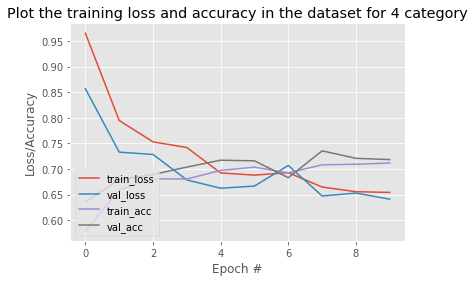

In [ ]:
# Plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Plot the training loss and accuracy in the dataset for 4 category")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# Salve o Modelo 
model.save('Covid_Multi.h5')

### Predict

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size = 1,
        shuffle = True,
        seed = 42,
        class_mode = "categorical")
eval_generator.reset()

x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1)

print('Test loss:' , x[0])
print('Test accuracy:', x[1])

# O conjunto de dados foi modificado para um conjunto de dados bem significativo com mais de 5.000 imagens

Found 1206 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
121/121 [==============================] - 2s 18ms/step - loss: 0.5660 - acc: 0.7769 - precision: 0.7797 - recall: 0.7603
Test loss: 0.5659582018852234
Test accuracy: 0.7768595218658447


In [ ]:
# Prever 1
eval_generator.reset()  
pred = model.predict_generator(eval_generator, 1000, verbose = 1)
print("Previsões concluídas")

Instructions for updating:
Please use Model.predict, which supports generators.
1000/1000 [==============================] - 15s 15ms/step
Previsões concluídas


In [ ]:
pred

array([[3.98032484e-04, 3.85010652e-02, 5.70711493e-01, 3.90389413e-01],
       [1.37400841e-02, 9.04198468e-01, 6.40414283e-02, 1.80200152e-02],
       [1.34839865e-04, 3.94869223e-03, 9.38221335e-01, 5.76950461e-02],
       ...,
       [1.11825706e-04, 6.99920058e-02, 3.22295725e-01, 6.07600451e-01],
       [6.31849543e-05, 1.25963287e-03, 9.33355570e-01, 6.53216243e-02],
       [4.22737515e-03, 4.97034118e-02, 7.61508405e-01, 1.84560806e-01]],
      dtype=float32)

### Results (4 classes: Normal, Bacterial, Viral, COVID19)

Ajuste fino com uma taxa de aprendizagem de 5E-5.

A otimização de Adam é um método de descida gradiente estocástico que se baseia na estimativa adaptativa de momentos de primeira e segunda ordem.

De acordo com Kingma et al., 2014 , o método é "computacionalmente eficiente, tem pouca necessidade de memória, invariante para o reescalonamento diagonal de gradientes e é adequado para problemas que são grandes em termos de dados/parâmetros".



In [ ]:
# Um otimizador é um dos dois argumentos necessários para compilar um modelo Keras
# O valor padrão de 1e-7 para epsilon pode não ser um bom padrão em geral. 
# Por exemplo, ao treinar uma rede Inception no ImageNet, uma boa escolha atual é 1.0 ou 0.1

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 5e-5), # aprendizagem de 5E-5
              metrics = ['acc', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")])

result = model.fit_generator(train_batches,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        callbacks = [checkpoint_cb, early_stopping_cb],
                        epochs= 10)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
333/333 [==============================] - 67s 200ms/step - loss: 0.6239 - acc: 0.7288 - precision: 0.7567 - recall: 0.6890 - val_loss: 0.6061 - val_acc: 0.7695 - val_precision: 0.7871 - val_recall: 0.6988
Epoch 2/10
333/333 [==============================] - 66s 197ms/step - loss: 0.6243 - acc: 0.7276 - precision: 0.7598 - recall: 0.6857 - val_loss: 0.6445 - val_acc: 0.7037 - val_precision: 0.7304 - val_recall: 0.6707
Epoch 3/10
333/333 [==============================] - 65s 195ms/step - loss: 0.6261 - acc: 0.7258 - precision: 0.7559 - recall: 0.6824 - val_loss: 0.6376 - val_acc: 0.7244 - val_precision: 0.7540 - val_recall: 0.6878
Epoch 4/10
333/333 [==============================] - 65s 195ms/step - loss: 0.6264 - acc: 0.7252 - precision: 0.7550 - recall: 0.6845 - val_loss: 0.6266 - val_acc: 0.7500 - val_precision: 0.7820 - val_recall: 0.7085
Epoch 5/10
333/333 [==============================] - 65s 196ms/step - loss: 0.6136 - acc: 0.7297 - precision: 0.7628 - recall: 0.69

In [ ]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers = 1)

print('Test loss:', x[0])
print('Test accuracy:', x[1])

121/121 [==============================] - 2s 18ms/step - loss: 0.5132 - acc: 0.8347 - precision: 0.8545 - recall: 0.7769
Test loss: 0.513195276260376
Test accuracy: 0.8347107172012329


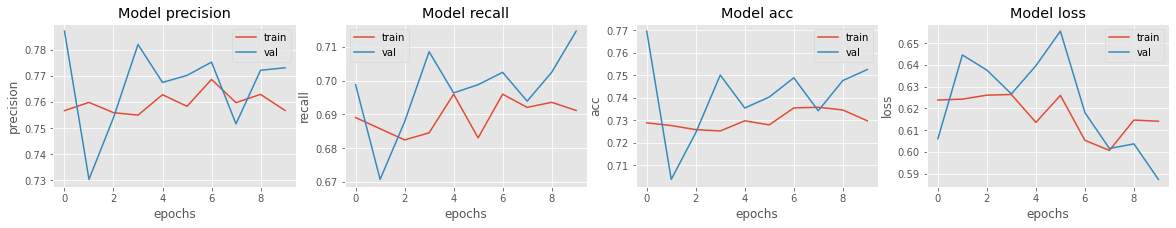

In [ ]:
# Verificando as Métricas

fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "acc", "loss"]):
    ax[i].plot(result.history[met])
    ax[i].plot(result.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

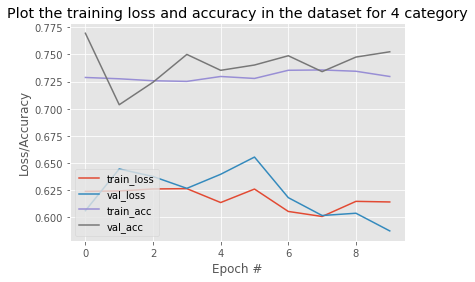

In [ ]:
# Plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Plot the training loss and accuracy in the dataset for 4 category")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size = 1,
        shuffle = True,
        seed = 42,
        class_mode = "categorical")
eval_generator.reset()

x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1)

print('Test loss:' , x[0])
print('Test accuracy:', x[1])

Found 1206 images belonging to 4 classes.
121/121 [==============================] - 2s 18ms/step - loss: 0.4931 - acc: 0.8347 - precision: 0.8571 - recall: 0.7934
Test loss: 0.493055522441864
Test accuracy: 0.8347107172012329


### Inicialização de VGG COVID19 vs Normal vs Pneumonia Terciária (Bacteriana)

*   3 Classes


In [ ]:
# Habilite esta célula para remover a classe de pneumonia viral. Lembre-se de alterar a camada final do modelo para 3 neurônios

# Habilite esta célula para remover a classe de pneumonia viral or all. 
# Lembre-se de alterar a camada final do modelo para 3 ou 4 neurônios.

# Exclua algumas classes que podem interferir
!rm -rf /content/Covid_Data_GradientCrescent/all/test/pneumonia_vir
!rm -rf /content/Covid_Data_GradientCrescent/all/train/pneumonia_vir


In [ ]:
from os import listdir
data_list = listdir('/content/Covid_Data_GradientCrescent/all/train')

# Exclua algumas classes que podem interferir
data_list

['pneumonia_bac', 'covid', 'normal']

In [ ]:
DATASET_PATH  = '/content/Covid_Data_GradientCrescent/all/train'
test_dir =  '/content/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  
NUM_EPOCHS    = 10
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.25,
                                   zoom_range = 0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode = "categorical"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size = IMAGE_SIZE,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  subset = "validation",
                                                  seed = 42,
                                                  class_mode = "categorical")

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2456 images belonging to 3 classes.
Found 611 images belonging to 3 classes.


In [ ]:
# Modelo CNN simples baseado em VGG16. Defina a contagem de neurônios de camada densa para 3 se a classe de pneumonia viral for removida.
from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# Modelo 1 com 3 classes
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.Adam(lr=LEARNING_RATE),
metrics = ['acc', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")])

In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN = train_batches.n//train_batches.batch_size
STEP_SIZE_VALID = valid_batches.n//valid_batches.batch_size

result = model.fit_generator(train_batches,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs = NUM_EPOCHS)

246
62
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


245/245 [==============================] - 52s 210ms/step - loss: 0.5142 - acc: 0.7980 - precision: 0.8122 - recall: 0.7817 - val_loss: 0.3520 - val_acc: 0.8623 - val_precision: 0.8690 - val_recall: 0.8590
Epoch 2/10
245/245 [==============================] - 51s 208ms/step - loss: 0.3521 - acc: 0.8630 - precision: 0.8684 - recall: 0.8549 - val_loss: 0.4158 - val_acc: 0.7967 - val_precision: 0.8020 - val_recall: 0.7902
Epoch 3/10
245/245 [==============================] - 51s 208ms/step - loss: 0.3074 - acc: 0.8843 - precision: 0.8920 - recall: 0.8749 - val_loss: 0.3687 - val_acc: 0.8525 - val_precision: 0.8612 - val_recall: 0.8443
Epoch 4/10
245/245 [==============================] - 51s 210ms/step - loss: 0.2813 - acc: 0.8896 - precision: 0.8953 - recall: 0.8806 - val_loss: 0.3079 - val_acc: 0.8885 - val_precision: 0.8937 - val_recall: 0.8820
Epoch 5/10
245/245 [==============================] - 51s 208ms/step - loss: 0.2722 - acc: 0.8978 - precision: 0.9017 - recall: 0.8921 - val_lo

In [ ]:
model.save('Covid_Multi2.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size = IMAGE_SIZE,
        batch_size = 1,
        shuffle = True,
        seed = 42,
        class_mode = "categorical")
eval_generator.reset()

Found 932 images belonging to 3 classes.


In [ ]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1)

print('Test loss:', x[0])
print('Test accuracy:', x[1])

94/94 [==============================] - 2s 18ms/step - loss: 0.4300 - acc: 0.8617 - precision: 0.8617 - recall: 0.8617
Test loss: 0.43003934621810913
Test accuracy: 0.8617021441459656


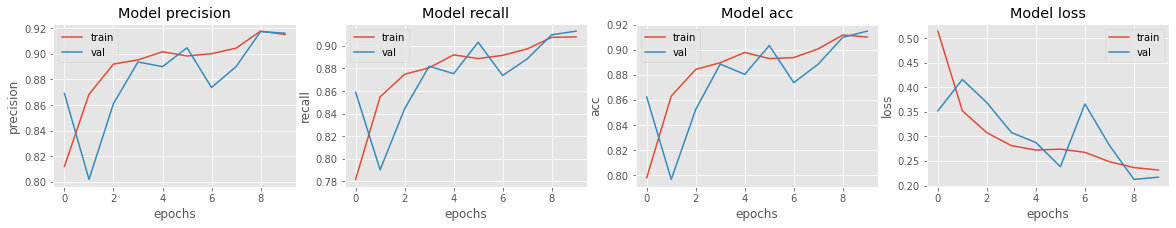

In [ ]:
# Verificando as Métricas
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "acc", "loss"]):
    ax[i].plot(result.history[met])
    ax[i].plot(result.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

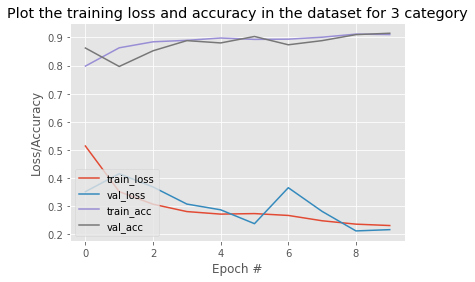

In [ ]:
# Plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Plot the training loss and accuracy in the dataset for 3 category")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")

In [ ]:
# Modelo 2 com 3 classes
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 5e-5), # aprendizagem de 5E-5
              metrics = ['acc', tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")])

result = model.fit_generator(train_batches,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= 10)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
245/245 [==============================] - 51s 208ms/step - loss: 0.2097 - acc: 0.9186 - precision: 0.9203 - recall: 0.9154 - val_loss: 0.2482 - val_acc: 0.8967 - val_precision: 0.8967 - val_recall: 0.8967
Epoch 2/10
245/245 [==============================] - 51s 208ms/step - loss: 0.2115 - acc: 0.9109 - precision: 0.9148 - recall: 0.9088 - val_loss: 0.2396 - val_acc: 0.9082 - val_precision: 0.9079 - val_recall: 0.9049
Epoch 3/10
245/245 [==============================] - 50s 206ms/step - loss: 0.2239 - acc: 0.9129 - precision: 0.9161 - recall: 0.9105 - val_loss: 0.2229 - val_acc: 0.9164 - val_precision: 0.9163 - val_recall: 0.9148
Epoch 4/10
245/245 [==============================] - 51s 208ms/step - loss: 0.2126 - acc: 0.9178 - precision: 0.9209 - recall: 0.9137 - val_loss: 0.1815 - val_acc: 0.9377 - val_precision: 0.9376 - val_recall: 0.9361
Epoch 5/10
245/245 [==============================] - 51s 207ms/step - loss: 0.2107 - acc: 0.9182 - precision: 0.9195 - recall: 0.91

In [ ]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers = 1)

print('Test loss:' , x[0])
print('Test accuracy:',x[1])

94/94 [==============================] - 2s 18ms/step - loss: 0.2105 - acc: 0.9043 - precision: 0.9043 - recall: 0.9043
Test loss: 0.2105167657136917
Test accuracy: 0.9042553305625916


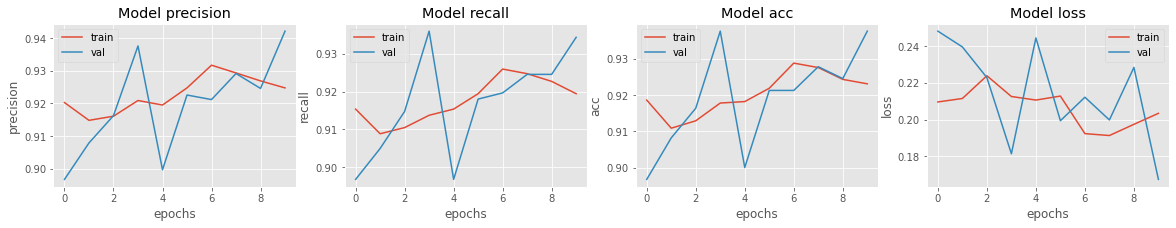

In [ ]:
# Verificando as Métricas

fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "acc", "loss"]):
    ax[i].plot(result.history[met])
    ax[i].plot(result.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

**Observe que temos ainda algumas métricas acima: Precision, Recall e Acc.**

**A precisão** pode ser usada em uma situação em que os Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos. 

**O recall** pode ser usado em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos. Por exemplo, o modelo deve de qualquer maneira encontrar todos os pacientes doentes, mesmo que classifique alguns saudáveis como doentes (situação de Falso Positivo) no processo. Ou seja, o modelo deve ter alto recall, pois classificar pacientes doentes como saudáveis pode ser uma tragédia.

Assim, para o nosso cenário o Recall consegue ter uma importância maior que a acurácia. De fato não queremos mandar para casa algum paciente que esteja com suspeita de infecção pelo COVID-19, alegando que o mesmo não tem nada. Assim, conseguimos um Recall de 92% para as classes positivas, àquelas que possuem o COVID-19.

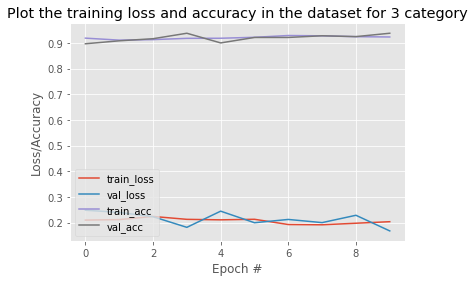

In [ ]:
# Plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Plot the training loss and accuracy in the dataset for 3 category")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")

### **Conclusão**

Conforme foi discutido em "Adrian Yijie Xu, “Detecting COVID-19 induced Pneumonia from Chest X-rays with Transfer Learning: An implementation in Tensorflow and Keras".

*   50% de precisão para 4 classes (Saudável, COVID-19, Bacteriana e Viral), 308 Imagens, 100 Epoch.
*   80% de precisão para 3 classes (Saudável, COVID-19, Bacteriana), 227 Imagens, 100 Epoch.
*   100% de precisão para 2 classes (Saudável e Covid19), 148 Imagens, 20 Epoch.

Para nossos estudos comparativos usando VGG16:

*   74% acc para 4 classes (Saudável, COVID-19, Bacteriana e Viral), 5551 Imagens, 10 Epoch.
*   91% acc para 3 classes (Saudável, COVID-19, Bacteriana), 4133 Imagens, 10 Epoch.
*   97% acc para 2 classes (Saudável e Covid19), 1704 Imagens.

Para nossos estudos comparativos usando CNN-LSTM:

*   precisão para 3 classes (Saudável, COVID-19, Bacteriana), Imagens, Epoch.
*   precisão para 4 classes (Saudável, COVID-19, Bacteriana e Viral), Imagens, Epoch.

**Discussão:** 

Pneumonia viral indistinguível de COVID19: aceitável, visto que a própria COVID19 é causada por via viral.

---
### **Referências**

*M. Z. Islam, M. M. Islam, and A. Asraf, “A combined deep CNN-LSTM network for the detection of novel coronavirus (COVID-19) using X-ray images”, Informatics in Medicine Unlocked, Jun., 2020.
Available:
https://doi.org/10.1016/j.imu.2020.100412*

*Adrian Yijie Xu, “Detecting COVID-19 induced Pneumonia from Chest X-rays with Transfer Learning: An implementation in Tensorflow and Keras”,
https://towardsdatascience.com/detecting-covid-19-induced-pneumonia-from-chest-x-rays-with-transfer-learning-an-implementation-311484e6afc1*

*Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), "Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification", Mendeley Data, V2, doi: 10.17632 / rscbjbr9sj.2
http://dx.doi.org/10.17632/rscbjbr9sj.2
https://data.mendeley.com/datasets/rscbjbr9sj/2* 

*MDPI and ACS Style
Haque, K.F.; Abdelgawad, A. A Deep Learning Approach to Detect COVID-19 Patients from Chest X-ray Images. AI 2020, 1, 418-435.*

*https://www.researchgate.net/publication/341677998_A_modified_deep_convolutional_neural_network_for_detecting_COVID-19_and_pneumonia_from_chest_X-ray_images_based_on_the_concatenation_of_Xception_and_ResNet50V2*

*https://github.com/HzFu/COVID19_imaging_AI_paper_list*

*https://github.com/datasets/covid-19*


